In [1]:
import pandas as pd
import ipcalc
import parse_functions as pf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import user_agents as ua
from helpers import filter_other, autopct_format
import calendar

# Vorbereitung: Einlesen der Daten

_Vorstellung: Flo_

- Für die Analsyse müssen die Daten der `acces.log`-Datei eingelesen werden!

## Schwierigkeit

- Größe des Datensatzes: 10.365.152 Log Einträge (über 10 Milionen)
- keine eindeutiges Trennzeichen in den Daten vorhanden
- kein von Pandas vorgefertigter Import für Log Dateien

**So sehen die Anfragen aus:**
```
31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] "GET /image/60844/productModel/200x200 HTTP/1.1" 200 5667 "https://www.zanbil.ir/m/filter/b113" "Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36" "-"

31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] "GET /image/61474/productModel/200x200 HTTP/1.1" 200 5379 "https://www.zanbil.ir/m/filter/b113" "Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36" "-"
```

## Lösung

- Nutzung des Read_CSV Befehls angewandt auf die `acces.log`-Datei
- Anwendung möglich durch die Angabe des Seperators mitthilfe einer Regular Expression ```sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\]\s)'```
- Nach eindeutiger zuordnung des Trennzeichens können Daten eingelesen werden!

**Nachteil:** Die Ladezeit ist aufgrund der Größe des Datensatzes relativ lang (ca. 10-15 Minuten)

In [2]:
# Source: https://mmas.github.io/read-apache-access-log-pandas
access_log = pd.read_csv(
    'data/access.log',
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\]\s)',
    engine='python',
    na_values='-',
    header=None,
    usecols=[0, 3, 4, 5, 6, 7, 8],
    names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'time': pf.parse_datetime,
                'request': pf.parse_str,
                'status': int,
                'size': int,
                'referer': pf.parse_str,
                'user_agent': pf.parse_str},
    on_bad_lines='warn')

access_log.head()


,ip,time,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...


## Umwandlung in CSV Datei

Nachdem Daten eingelesen wurden diese direkt als CSV-Datei "zwischenspeichern"

**Vorteil:** Verkürzt die Ladezeit auf ca. 3-4 Minuten

- CSV Datei kann genutzt werden um die Daten erneut einzulesen
- Das Einladen über die strukturierte CSV Datei geht deutlich schneller als laden der Daten aus der `acces.log`-Datei

In [7]:
# Daten in einer CSV Datei speichern
filename = "data/acces_log.csv"
access_log.to_csv(filename, index=False)

## Daten aus CSV laden
- Die Daten aus der zuvor genrierten CSV Datei laden. 

**Wichtig:** Es muss zuvor die CSV Datei generiert werden, indem mindestens einmal die Daten aus der acces.log Datei eingelesen wurden!
- dieser Schritt wird also erst bei der mehrfachen Ausführung des Notebooks sinnvoll! 

In [5]:
# Daten aus CSV laden
filename = "data/acces_log.csv"
access_log = pd.read_csv(filename)

access_log.head()

,Unnamed: 0,ip,time,request,status,size,referer,user_agent
0,0,54.36.149.41,2019-01-22 00:26:14+00:00,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,1,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,2,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,3,40.77.167.129,2019-01-22 00:26:17+00:00,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,4,91.99.72.15,2019-01-22 00:26:17+00:00,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...


In [ ]:
# Erzeuge eine Kopie der Daten als "Backup" 
access_log_backup = access_log.copy()
len(access_log_backup)

## Daten konvertieren & normalisieren
Die in der CSV hinterlegten Daten in die benötigten Datentypen überführen

- time: soll als Datum im Pandas Dataframe hinterlegt und entsprechend Normalisiert werden!

In [11]:
# Typen konvertieren
access_log['time'] = pd.to_datetime(access_log['time'])

# Daten normalisieren
access_log['time'] = access_log['time'].dt.tz_convert('UTC')

# Aufgabe 1: Beliebtestes Produkt

_Vorstellung: Tom_

> Analysieren Sie welche Produkte beliebt sind. Entwickeln Sie dazu eine Definition eines beliebten Produktes. Stellen Sie die Ergebnisse anschaulich da.

## Definition

> Das Produkt mit dein meisten Aufrufen auf dem Webserver

## Ergebnis

> Das Product mit der ProductID 33968 wurde am häufigsten aufgerufen! Hierbei handelt es sich um das: Galaxy-J6-Plus-Dual-32GB


In [35]:
def extract_product_id(request):
  m = re.search(r"\s\/product\/(\d+)\/", str(request))
  if m:
    return m.group(1)
  return None

access_log['product_id'] = access_log['request'].map(extract_product_id)
access_log.head()

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,date,weekday_n,...,device_family,device_brand,device_model,is_mobile,is_pc,is_bot,GET,HEAD,POST,product_id
0,0,54.36.149.41,2019-01-22 00:26:14+00:00,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,2019-01-22,1,...,Spider,Spider,Desktop,False,False,True,True,False,False,None
1,1,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,2019-01-22,1,...,ALE-L21,Huawei,ALE-L21,True,False,False,True,False,False,None
2,2,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,2019-01-22,1,...,ALE-L21,Huawei,ALE-L21,True,False,False,True,False,False,None
3,3,40.77.167.129,2019-01-22 00:26:17+00:00,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,2019-01-22,1,...,Spider,Spider,Desktop,False,False,True,True,False,False,None
4,4,91.99.72.15,2019-01-22 00:26:17+00:00,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,2019-01-22,1,...,Other,None,None,False,True,False,True,False,False,31893


764 x ID: 33953


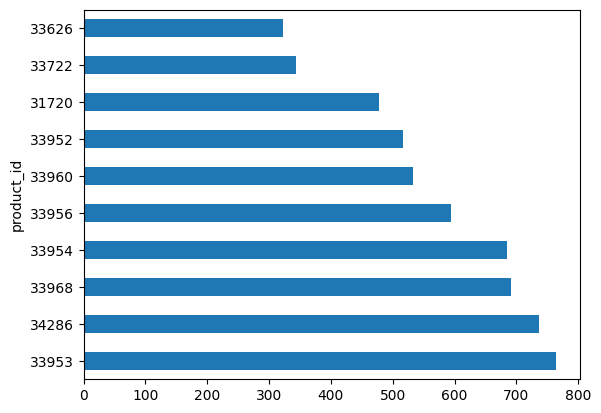

In [36]:
most_viewed_products = access_log.loc[access_log['product_id'] != None].value_counts(access_log['product_id'])
most_viewed_products = most_viewed_products[0:10]
most_viewed_products.plot(kind='barh')
most_viewed_product_id = most_viewed_products.keys()[0]
print(most_viewed_products[0], 'x', 'ID:', most_viewed_product_id)

# TODO: Display Product for Id (flo)

# Aufgabe 2

> Untersuchen Sie den Datensatz auf weitere Auffälligkeiten.


## Basisinformationen durch Pandas-Befehle
- Pandas bietet bereits vordefinierte Befehle um einfache Informationen über die Daten zu ermitteln
- Mit den Befehlen zu beginnen, hilft dabei die Daten ein erstes mal zu erkunden!
- Speziell bei numerrischen Daten erhält man bereits eine Reihe an spannenden statistischen Informationen
- Auch für Daten wie die des Logs, lohnt es sich kurz beide Befehle anzugucken!

### Befehl `.info()`
- Übersicht über die Spalten
- Angabe zu den Datentypen der Spalten

In [ ]:
access_log.info()

### Befehl `.describe()`
- Anzahl der Einträge
- wie viele einzigartige Einträge
- höchste Zahl
- Durchschintt
- weitere statistische Angaben!

--> Statistische Basisinformationen <br>
--> Parameter `include = 'all'` notwendig, dass auch nicht numerische Daten in die Übersicht mit übernommen werden



In [ ]:
access_log.describe(include = 'all')

## Daten anzeigen

- Zum Anzeigen der Daten können unterschiedliche Methoden genutzt werden
- Anzeigen durch Methoden: ` .head(x) | .tail(x) ` gibt die ersten / letzten x Zeilen aus
- indizierter Zugriff wie aus Python bekannt `acces_log[10000:10200]`

In [ ]:
access_log.head(5)

In [ ]:
access_log[10000:10200]

## Einfache Analyse der Anzahl einzelner Features

- Zählen der Features durch `.value_counts("feature")`
  - ermitteln welche IP Adresse die meisten Anfragen stellt
  - Welches Produkt wurde am meisten angefragt (Aufgabe 1)

In [ ]:
# IP-Adressen mit den meisten Aufrufen 
access_log.value_counts("ip").head()

In [ ]:
referer_counts = access_log.loc[access_log['referer'] != None]['referer'].value_counts()
referer_counts.head(10).plot(kind="barh")

In [ ]:
# Pie Plot mit allen weiteren Links
referer_counts = access_log.loc[access_log['referer'] != None]['referer'].value_counts()
referer_counts = filter_other(referer_counts, 0.01)
referer_counts.plot(kind='pie', title='Request Methods', ylabel='Method', autopct=autopct_format(referer_counts))

## Datenergänzung / Datenaufbereitung zur Analyse

### Timestamps

- Zur Analyse des Timestamps werden einzelne Spalten für Wochentag (numerisch), Stunde und Datum erstellt
- Die neu erstellten Features können für Untersuchungen zu den Aufrufe nach Tageszeit / Tagen verwendet werden

In [12]:
access_log['date'] = access_log['time'].dt.date
access_log['weekday_n'] = access_log['time'].dt.weekday
access_log['weekday'] = access_log['weekday_n'].map(lambda wd: calendar.day_name[wd])
access_log['hour'] = access_log['time'].dt.hour

access_log.head()

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,date,weekday_n,weekday,hour
0,0,54.36.149.41,2019-01-22 00:26:14+00:00,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,2019-01-22,1,Tuesday,0
1,1,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,2019-01-22,1,Tuesday,0
2,2,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,2019-01-22,1,Tuesday,0
3,3,40.77.167.129,2019-01-22 00:26:17+00:00,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,2019-01-22,1,Tuesday,0
4,4,91.99.72.15,2019-01-22 00:26:17+00:00,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,2019-01-22,1,Tuesday,0


## Analyse der herausgearbeiteten Timestamp Eigenschaften 

- Analyse der Aufrufe je Tag
- Analyse der Aufrufe je Stunden

Darstellung beider Daten als Balkendiagramm

In [ ]:
# Analyse der Tage (Zugriffstage)
days_count = access_log.value_counts('date')
print(days_count)
days_count.sort_index().plot(kind='bar')

## Auswertung Tagesanzahl

- Die Log-Datei enthält Informationen zu 5 Tagen
- Die ersten beiden Tage haben eine leicht höhere Anzahl an Anfragen, ansonsten aber eine relativ gleiche Verteilung der Last über alle Tage

In [ ]:
# Analyse der Stunden (Zugriffszeiten)
hours_count = access_log.value_counts('hour')
print(hours_count.head())
hours_count.sort_index().plot(kind='bar')

## Auswertung Stundenanalyse (Zugriffszeiten)

- Klares Tief in der Nacht zu erkennen
- Morgens ab 5 Uhr steigt die Anzahl an Aufrufen rapide
- Hochpunkt ist zwischen 8:00 und 9;00 Uhr morgens
- Über den Nachmittag zum Abend hin sinken die Aufrufe wieder deutlich

### Heatmap Tageszeit

_Vorstellung: Flo_

- Alternative visualisierung der Tageszeiten

In [ ]:
daytime_access = access_log.groupby(['hour']).size().to_frame(name = 'count').reset_index()

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
df_wide = daytime_access.pivot_table(columns='hour', values='count', aggfunc=lambda x:x)
heatmap = sns.heatmap(df_wide, linewidths=1.0,ax=ax)

ax.set_xlim(0, 23)
ax.set_ylim(0, 1)

heatmap.set_title('Aufrufe nach Tageszeit')
heatmap.set_xlabel('Uhrzeit')


Die Wochentage sind folgendermaßen ablesbar:

| Nr. | Wochentag |
| --- | --- |
| 0 | Mo |
| 1 | Di |
| 2 | Mi |
| 3 | Do |
| 4 | Fr |
| 5 | Sa |
| 6 | So |

Text(33.22222222222222, 0.5, 'Wochentag')

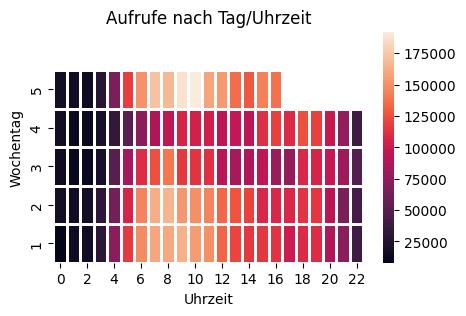

In [14]:
daytime_access = access_log.groupby(['weekday_n', 'hour']).size().to_frame(name = 'count').reset_index()

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
df_wide = daytime_access.pivot_table(index='weekday_n',columns='hour',values='count', aggfunc=lambda x:x)
heatmap = sns.heatmap(df_wide, linewidths=1.0,ax=ax)

ax.set_xlim(0, 23)
ax.set_ylim(0, 6)
# ax.set_yticks(range(0, 7), ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So'])

heatmap.set_title('Aufrufe nach Tag/Uhrzeit')
heatmap.set_xlabel('Uhrzeit')
heatmap.set_ylabel('Wochentag')

# TODO: Tage statt Zahlen? (tom)


## Request Methods

Herausarbeiten welche unterschiedlichen Requests an den Server gestellt wurden

Die folgenden Request Methoden gibt es:  
`GET`, `HEAD`, `POST`, `PUT`, `DELETE`, `CONNECT`, `OPTIONS`, `TRACE` und `PATCH`

Hierzu wird auf die Spalte `request` die Methode mit der Funktion `extract_method(str)` extrahiert  
Die Extraktion erfolgt mittels der Regular Expression `^[A-Z]+`, die alle Großbuchstabenn vom Beginn des Request ausliest.

In [15]:
def extract_method(request):
  "Method to extract the HTTP-Method for a Request"
  m = re.match(r'^[A-Z]+', str(request))
  if m:
    return m.group()
  return None

access_log['method'] = access_log['request'].map(extract_method)
access_log.head()

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,date,weekday_n,weekday,hour,method
0,0,54.36.149.41,2019-01-22 00:26:14+00:00,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,2019-01-22,1,Tuesday,0,GET
1,1,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,2019-01-22,1,Tuesday,0,GET
2,2,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,2019-01-22,1,Tuesday,0,GET
3,3,40.77.167.129,2019-01-22 00:26:17+00:00,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,2019-01-22,1,Tuesday,0,GET
4,4,91.99.72.15,2019-01-22 00:26:17+00:00,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,2019-01-22,1,Tuesday,0,GET


method
GET         10190005
POST          139155
HEAD           34501
OPTIONS         1424
CONNECT           10
G                  6
E                  4
PROPFIND           3
Name: count, dtype: int64
10365108


<Axes: title={'center': 'Request Methods'}, ylabel='Method'>

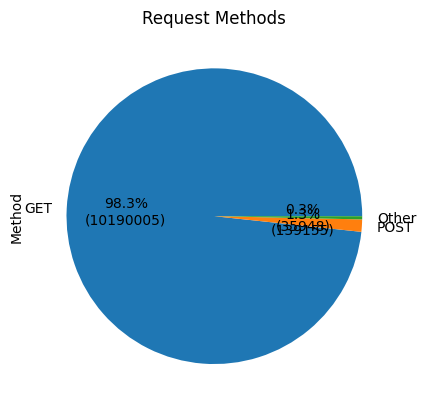

In [16]:
method_counts = access_log.loc[access_log['method'] != None]['method'].value_counts()

# Ausgabe der Methods
print(method_counts)

# Plot
method_counts_other = filter_other(method_counts, 0.005)
method_counts_other.plot(kind='pie', title='Request Methods', ylabel='Method', autopct=autopct_format(method_counts_other))

<Axes: title={'center': 'Request Methods (excl. GET)'}, xlabel='method', ylabel='Requests'>

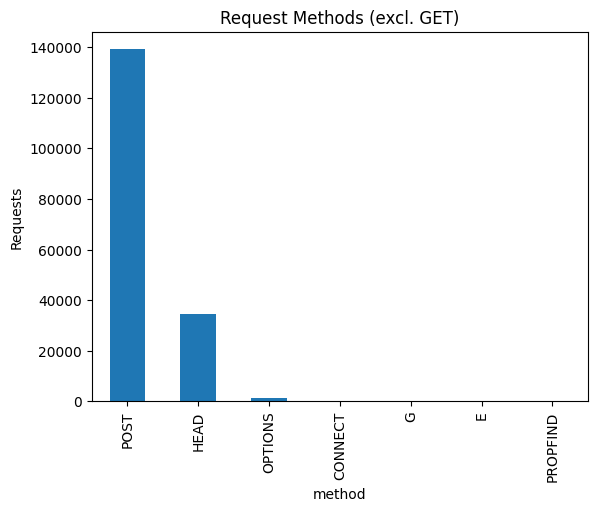

In [18]:
method_counts_without_get = method_counts.drop(labels = 'GET')
method_counts_without_get.plot(kind='bar', title='Request Methods (excl. GET)', ylabel='Requests')

## Auswertung RequestMethoden

- Sehr hohe Anzahl von Get Requests 98.3%
- Es existieren aber auch andere Reqeust
- 1.3% Post Requests
- Weitere Requests: HEAD; OPTIONS; CONNECT; G; E; PROPFIND

**ToDo:** Herausfinden was diese Reqeusts tun? (offen)

In [22]:
post_requests = access_log.loc[access_log['method'] == 'POST']
post_requests.head()

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,date,weekday_n,weekday,hour,method
51,51,5.78.198.52,2019-01-22 00:26:26+00:00,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,2019-01-22,1,Tuesday,0,POST
55,55,5.78.198.52,2019-01-22 00:26:27+00:00,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,2019-01-22,1,Tuesday,0,POST
59,59,5.78.198.52,2019-01-22 00:26:28+00:00,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,2019-01-22,1,Tuesday,0,POST
62,62,5.78.198.52,2019-01-22 00:26:29+00:00,POST /m/updateVariation?__amp_source_origin=ht...,200,171,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,2019-01-22,1,Tuesday,0,POST
77,77,5.78.198.52,2019-01-22 00:26:30+00:00,POST /m/updateVariation?__amp_source_origin=ht...,200,394,https://www.zanbil.ir/m/product/33978/64784/%D...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,2019-01-22,1,Tuesday,0,POST


## User Agents, Browser & OS

TODO: Extra CSV erstellen! (flo)

TODO: Erläuterung! (flo)

TODO: Bot Ip adressen (flo)

In [23]:
agents = access_log['user_agent'].map(lambda agent: ua.parse(str(agent)))
access_log['browser_family'] = agents.map(lambda agent: agent.browser.family)
access_log['os_family'] = agents.map(lambda agent: agent.os.family)
access_log['device_family'] = agents.map(lambda agent: agent.device.family)
access_log['device_brand'] = agents.map(lambda agent: agent.device.brand)
access_log['device_model'] = agents.map(lambda agent: agent.device.model)
access_log['is_mobile'] = agents.map(lambda agent: agent.is_mobile)
access_log['is_pc'] = agents.map(lambda agent: agent.is_pc)
access_log['is_bot'] = agents.map(lambda agent: agent.is_bot)

access_log.head()

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,date,weekday_n,...,hour,method,browser_family,os_family,device_family,device_brand,device_model,is_mobile,is_pc,is_bot
0,0,54.36.149.41,2019-01-22 00:26:14+00:00,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,NaN,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,2019-01-22,1,...,0,GET,AhrefsBot,Other,Spider,Spider,Desktop,False,False,True
1,1,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,2019-01-22,1,...,0,GET,Chrome Mobile,Android,ALE-L21,Huawei,ALE-L21,True,False,False
2,2,31.56.96.51,2019-01-22 00:26:16+00:00,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,2019-01-22,1,...,0,GET,Chrome Mobile,Android,ALE-L21,Huawei,ALE-L21,True,False,False
3,3,40.77.167.129,2019-01-22 00:26:17+00:00,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,2019-01-22,1,...,0,GET,bingbot,Other,Spider,Spider,Desktop,False,False,True
4,4,91.99.72.15,2019-01-22 00:26:17+00:00,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,2019-01-22,1,...,0,GET,Firefox,Windows,Other,None,None,False,True,False


10365152


<Axes: title={'center': 'Browsers'}, ylabel='Browser'>

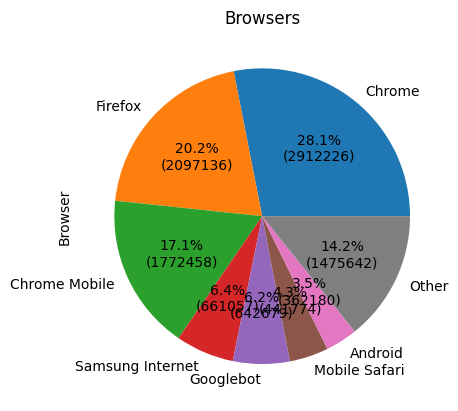

In [42]:
browser_family_counts = access_log['browser_family'].value_counts()

browser_family_counts = filter_other(browser_family_counts)

browser_family_counts.plot(kind='pie', title='Browsers', ylabel='Browser', autopct=autopct_format(browser_family_counts))

In [ ]:
os_family_counts = access_log['os_family'].value_counts()

os_family_counts = filter_other(os_family_counts)

os_family_counts.plot(kind='pie', title='OS', ylabel='OS', autopct=autopct_format(os_family_counts))

In [ ]:
bot_counts = access_log['is_bot'].value_counts()

bot_counts.plot(kind='pie', title='Bots', ylabel='Bots', autopct=autopct_format(bot_counts))

### Reevaluation von Aufgabe 1

Ändert sich das Ergebnis, wenn wir Bots ausschließen?

TODO: Anpassen auf Get Product Id von oben (flo)

In [ ]:
# Ergebnis von vorher
print('Ergebnis von vorher')
print(most_viewed_products[0], most_viewed_products.keys()[0])

print()

# Neues Ergebnis
print('Neues Ergebnis')
most_viewed_products2 = access_log.loc[access_log['is_bot'] != True].loc[access_log['request'].str.contains(r'^GET /product/\d+', na=False)].value_counts(access_log['request'])
print(most_viewed_products2[0], most_viewed_products2.keys()[0])

print()

# Evaluate
if most_viewed_products.keys()[0] == most_viewed_products2.keys()[0]:
    print('Gleiches Ergebnis')
else:
    print('Ergebnis verändert')
print('Differenz:', most_viewed_products[0] - most_viewed_products2[0], 'Bot-Aufrufe')

## Fehler

_Vorstellung: Tom_

TODO: Text (Tom :D)

In [ ]:
status_counts = access_log['status'].value_counts()

status_counts = filter_other(status_counts, 0.01)

status_counts.plot(kind='pie', title='Status', ylabel='Status Code', autopct=autopct_format(status_counts))

In [ ]:
error_counts = access_log['status'].map(lambda status: status >= 400).value_counts()

error_counts.plot(kind='pie', title='Failed requests', ylabel='Error?', autopct=autopct_format(error_counts))

In [ ]:
error_logs = access_log.loc[access_log['status'] >= 400]

error_code_counts = error_logs['status'].value_counts()

error_code_counts = filter_other(error_code_counts, 0.01)

error_code_counts.plot(kind='pie', title='Error', ylabel='Error Code', autopct=autopct_format(error_code_counts))

In [ ]:
error_logs = access_log.loc[access_log['status'] != 200]
error_logs.head()

## Korrelationsanalyse der Daten

TODO: Verbesserung der Analyse (tom)

Im folgenden wird eine Korrelationsanalyse auf den Daten ausgeführt um zu prüfen, ob einzelne Features miteinander korrelieren.

- **Anmerkung:** Aktuell liegen kaum Numerische Daten vor! -> Korrelation jedoch für numerische Daten zu berechnen
- **Vorgehen:** Die nicht numerischen Daten die mit untersucht werden sollen in numerische Daten umwandeln.

### Begründung Korrelationsanalyse

- Untersuchung auf weitere Datenzusammenhänge die vorliegen, aber noch nicht bekannt sind.
- **Beispiel:** Gibt es einen Zusammenhang zwischen der Tageszeit und Post Reqeusts?

In [ ]:
# Korrelationen auf den Daten ohne Ergänzung
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(access_log.corr(numeric_only=True), annot=True, cmap="PuOr", fmt=".1f", vmin=-1, vmax=1)

## Ergänzung um weitere Features (Nummerische Umwandlung)
- Damit andere Features integriert werden können müssen sie entsprechend umgewandelt werden können

### Vorgehen

- ```pd.get_dummies()``` Methode um aus einem Feature entsprechend mehrere Numerische Spalten zu erzeugen
- Jeder Eintrag des Features erhällt eine eigene Spalte, in der das entsprechende Feature mit ```true``` und ```false``` gekennzeichnet ist.

In [29]:
# Ergänzen um die Dummies Einträge für Method
methods_numeric = pd.get_dummies(access_log['method'])
methods_numeric

,CONNECT,E,G,GET,HEAD,OPTIONS,POST,PROPFIND
0,False,False,False,True,False,False,False,False
1,False,False,False,True,False,False,False,False
2,False,False,False,True,False,False,False,False
3,False,False,False,True,False,False,False,False
4,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...
10365147,False,False,False,True,False,False,False,False
10365148,False,False,False,True,False,False,False,False
10365149,False,False,False,True,False,False,False,False
10365150,False,False,False,True,False,False,False,False


In [30]:
# Anwendung der Dummie Einträge auf unseren Datensatz 
methods_numeric = methods_numeric.drop(['CONNECT','E','G','OPTIONS','PROPFIND'], axis=1)

access_log = access_log.join(methods_numeric)
access_log.head()

ValueError: columns overlap but no suffix specified: Index(['GET', 'HEAD', 'POST'], dtype='object')

<Axes: >

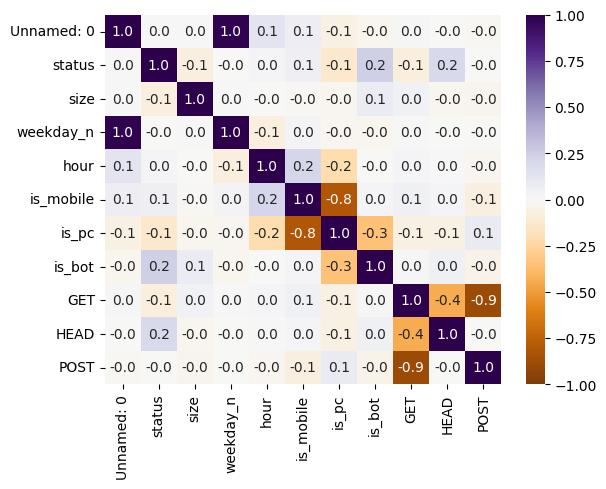

In [32]:
# Erneute Korrelationsanalyse
sns.heatmap(access_log.corr(numeric_only=True), annot=True, cmap="PuOr", fmt=".1f", vmin=-1, vmax=1)

#TODO: IP-Adresse

In [40]:
# Analyse der Korrelationen mit Product ID | TODo: wenn das gewünscht ist müssen wir die Product ID als Integer speichern! (tom)
access_log_copy = access_log.copy()

mask = access_log_copy["product_id"].notnull()
mask.value_counts()
access_log_copy = access_log_copy.loc[mask]
access_log_copy

,Unnamed: 0,ip,time,request,status,size,referer,user_agent,date,weekday_n,...,device_family,device_brand,device_model,is_mobile,is_pc,is_bot,GET,HEAD,POST,product_id
4,4,91.99.72.15,2019-01-22 00:26:17+00:00,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,NaN,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,2019-01-22,1,...,Other,None,None,False,True,False,True,False,False,31893
14,14,91.99.72.15,2019-01-22 00:26:19+00:00,GET /product/10075/13903/%D9%85%D8%A7%DB%8C%DA...,200,41725,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,2019-01-22,1,...,Other,None,None,False,True,False,True,False,False,10075
20,20,91.99.72.15,2019-01-22 00:26:20+00:00,GET /product/32798/63266/%DB%8C%D8%AE%DA%86%D8...,200,40250,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,2019-01-22,1,...,Other,None,None,False,True,False,True,False,False,32798
29,29,91.99.72.15,2019-01-22 00:26:21+00:00,GET /product/7793/9663/%D9%85%D8%A7%DB%8C%DA%A...,200,40889,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,2019-01-22,1,...,Other,None,None,False,True,False,True,False,False,7793
73,73,66.249.66.194,2019-01-22 00:26:29+00:00,GET /product/4057/47/78306 HTTP/1.1,200,41398,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,2019-01-22,1,...,Spider,Spider,Desktop,False,False,True,True,False,False,4057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10364232,10364232,40.77.167.122,2019-01-26 16:58:42+00:00,GET /product/31973/64992/%DA%AF%D9%88%D8%B4%DB...,200,41250,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,2019-01-26,5,...,Spider,Spider,Desktop,False,False,True,True,False,False,31973
10364753,10364753,66.249.66.194,2019-01-26 16:58:57+00:00,GET /product/11432/17311/%D8%AF%D9%88%DA%86%D8...,200,39789,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,2019-01-26,5,...,Spider,Spider,Desktop,False,False,True,True,False,False,11432
10365038,10365038,13.66.139.0,2019-01-26 16:59:08+00:00,GET /product/22837/48495/%D8%A7%D9%86%DA%AF%D8...,200,39933,NaN,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,2019-01-26,5,...,Spider,Spider,Desktop,False,False,True,True,False,False,22837
10365102,10365102,5.213.7.50,2019-01-26 16:59:11+00:00,GET /product/18962/%D8%BA%D8%B0%D8%A7-%D8%B3%D...,302,0,https://www.google.com/,Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...,2019-01-26,5,...,iPhone,Apple,iPhone,True,False,False,True,False,False,18962


In [41]:
type(access_log["product_id"][4])

str